In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib pandas scikit-learn tqdm


In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import clip
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define your base path
base_dir = "/content/drive/MyDrive/CS6365/outputs"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
models = [
    "DALL-E",
    "Firefly",
    "Midjourney",
    "stable_diffusion",
    "kandinsky"
]

# Define file prefixes for each model to match filenames
file_patterns = {
    "DALL-E": "DALL-E",
    "Firefly": "Firefly",
    "Midjourney": "Midjourney",
    "stable_diffusion": "sd_",
    "kandinsky": "kandinsky"
}

# Create a list of all files
all_images = []

for model in models:
    folder = os.path.join(base_dir, model)
    for file in os.listdir(folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            all_images.append({
                "filepath": os.path.join(folder, file),
                "model": model,
                "filename": file
            })

print(f"Found {len(all_images)} images.")


Found 300 images.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)


In [ ]:
embeddings = []
labels = []
filenames = []

for img_data in tqdm(all_images):
    try:
        image = Image.open(img_data["filepath"]).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = clip_model.encode_image(image_input).cpu().numpy()

        embeddings.append(image_features.flatten())
        labels.append(img_data["model"])
        filenames.append(img_data["filename"])
    except Exception as e:
        print(f"Error processing {img_data['filepath']}: {e}")

# Save as DataFrame for convenience
df = pd.DataFrame(embeddings)
df["model"] = labels
df["filename"] = filenames

print(df.shape)


100%|██████████| 300/300 [00:19<00:00, 15.48it/s]

(300, 514)


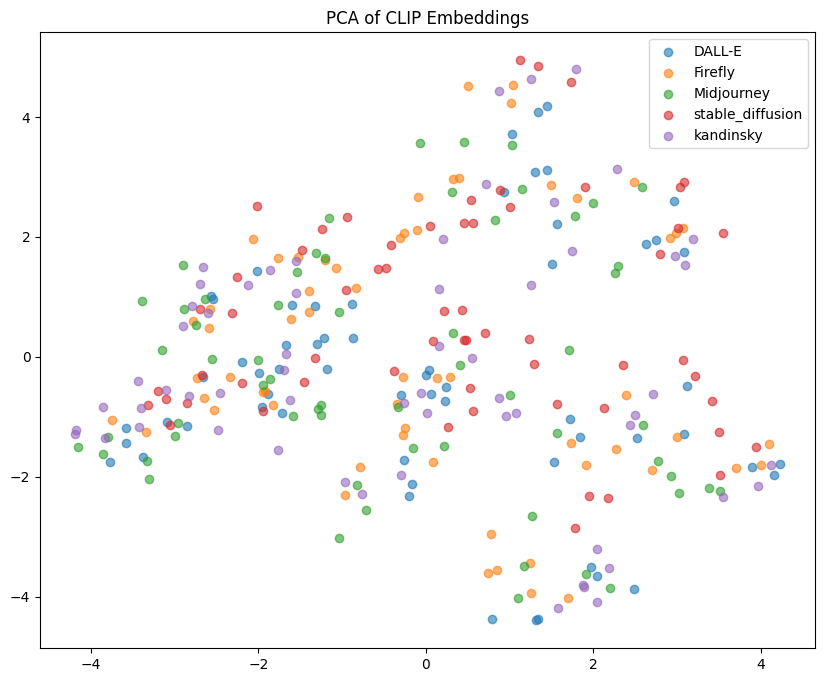

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(df.iloc[:, :-2])

plt.figure(figsize=(10,8))
for model in models:
    idx = df["model"] == model
    plt.scatter(coords[idx,0], coords[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title("PCA of CLIP Embeddings")
plt.show()


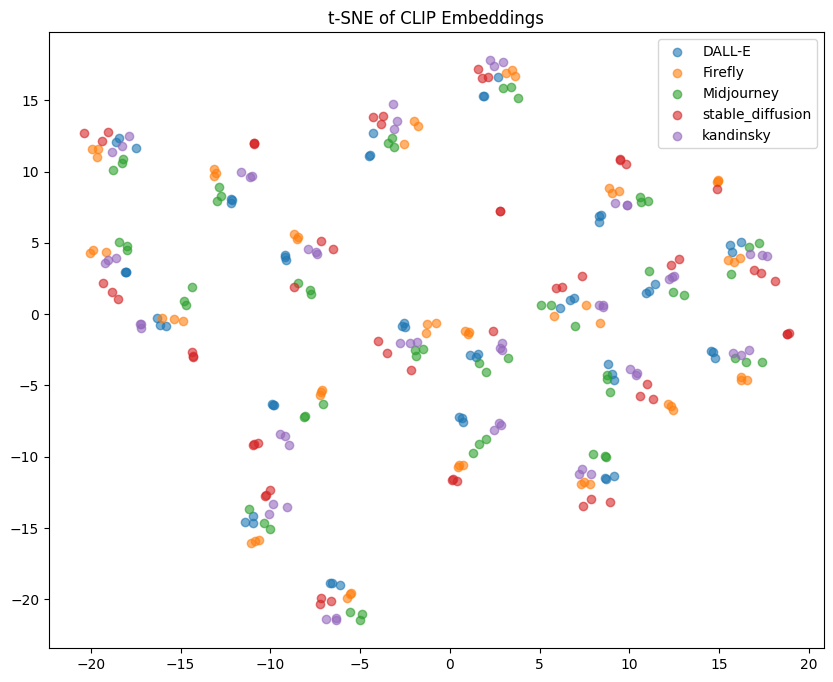

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords_tsne = tsne.fit_transform(df.iloc[:, :-2])

plt.figure(figsize=(10,8))
for model in models:
    idx = df["model"] == model
    plt.scatter(coords_tsne[idx,0], coords_tsne[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title("t-SNE of CLIP Embeddings")
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Identify the numeric embedding columns
embedding_cols = df.columns.difference(["model", "filename"])

# Group by model and compute mean embeddings
mean_embeddings = df.groupby("model")[embedding_cols].mean()

# Compute cosine similarities between mean embeddings
cos_sim = cosine_similarity(mean_embeddings.values)

# Create a DataFrame for readability
cos_sim_df = pd.DataFrame(
    cos_sim,
    index=mean_embeddings.index,
    columns=mean_embeddings.index
)

print(cos_sim_df)


model               DALL-E   Firefly  Midjourney  kandinsky  stable_diffusion
model                                                                        
DALL-E            1.000000  0.926642    0.960333   0.957665          0.930079
Firefly           0.926642  1.000000    0.955414   0.971290          0.958700
Midjourney        0.960333  0.955414    0.999999   0.978275          0.942862
kandinsky         0.957665  0.971290    0.978275   1.000000          0.966327
stable_diffusion  0.930079  0.958700    0.942862   0.966327          1.000000


In [ ]:
from itertools import combinations
import numpy as np

print("Pairwise model similarities:")

for m1, m2 in combinations(models, 2):
    idx1 = df["model"] == m1
    idx2 = df["model"] == m2

    embeds1 = df.loc[idx1, embedding_cols].values
    embeds2 = df.loc[idx2, embedding_cols].values

    # Compute pairwise cosine similarities
    distances = cosine_similarity(embeds1, embeds2)
    mean_sim = np.mean(distances)

    print(f"Average similarity between {m1} and {m2}: {mean_sim:.4f}")


Pairwise model similarities:
Average similarity between DALL-E and Firefly: 0.5546
Average similarity between DALL-E and Midjourney: 0.5793
Average similarity between DALL-E and stable_diffusion: 0.5426
Average similarity between DALL-E and kandinsky: 0.5849
Average similarity between Firefly and Midjourney: 0.5583
Average similarity between Firefly and stable_diffusion: 0.5412
Average similarity between Firefly and kandinsky: 0.5747
Average similarity between Midjourney and stable_diffusion: 0.5368
Average similarity between Midjourney and kandinsky: 0.5837
Average similarity between stable_diffusion and kandinsky: 0.5573


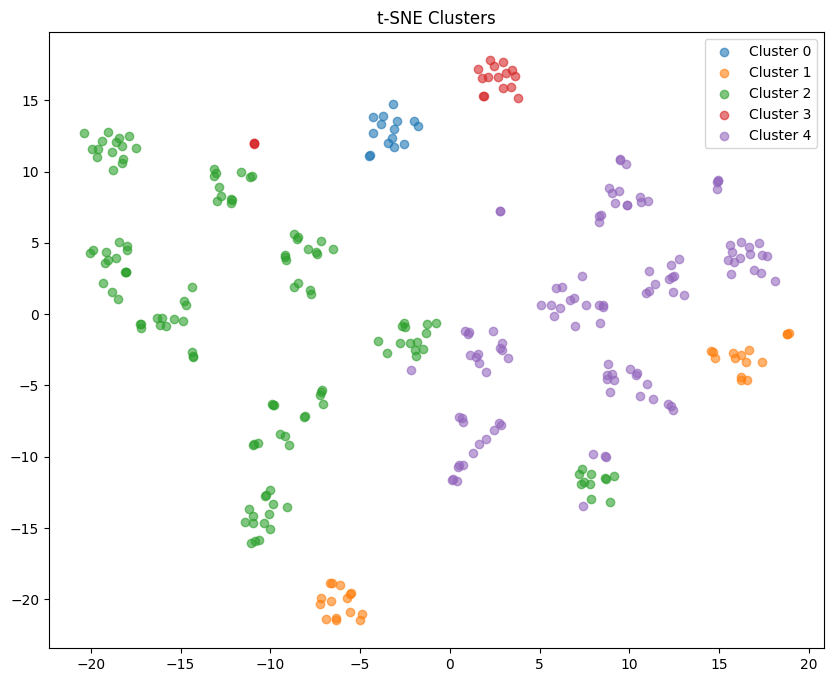

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels_cluster = kmeans.fit_predict(df.iloc[:, :-2])

df["cluster"] = labels_cluster

# Visualize clusters in t-SNE
plt.figure(figsize=(10,8))
for c in np.unique(labels_cluster):
    idx = df["cluster"] == c
    plt.scatter(coords_tsne[idx,0], coords_tsne[idx,1], label=f"Cluster {c}", alpha=0.6)
plt.legend()
plt.title("t-SNE Clusters")
plt.show()


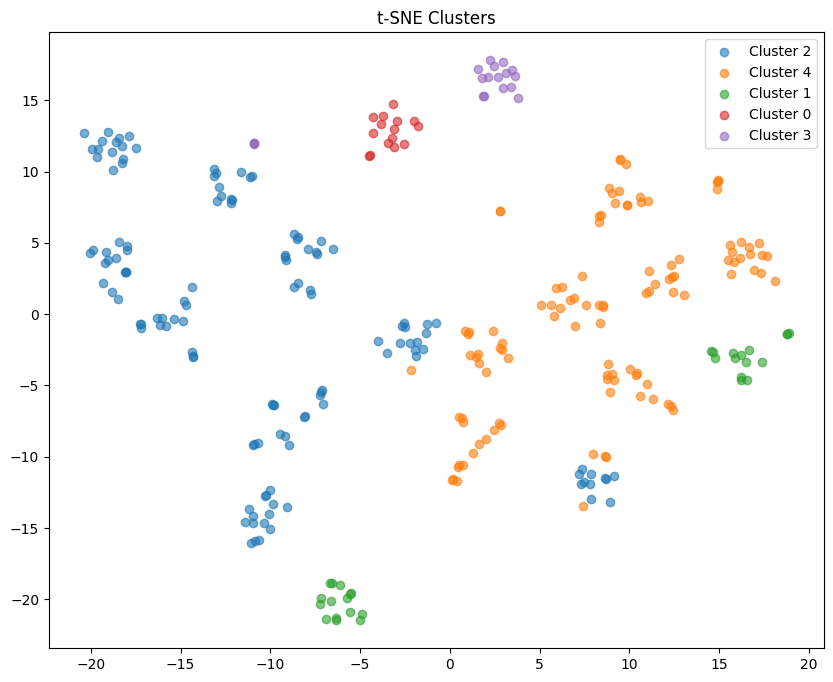

In [ ]:
plt.figure(figsize=(10,8))
for c in df["cluster"].unique():
    idx = df["cluster"] == c
    plt.scatter(coords_tsne[idx,0], coords_tsne[idx,1], label=f"Cluster {c}", alpha=0.6)
plt.legend()
plt.title("t-SNE Clusters")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Set how many clusters you want
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(df[embedding_cols])

# Count how many images per model fall into each cluster
cluster_summary = pd.crosstab(df["cluster"], df["model"])
print(cluster_summary)


model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             3        3           3          3                 3
1             6        6           6          6                 6
2            27       27          24         27                22
3             3        3           3          3                 6
4            21       21          24         21                23


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


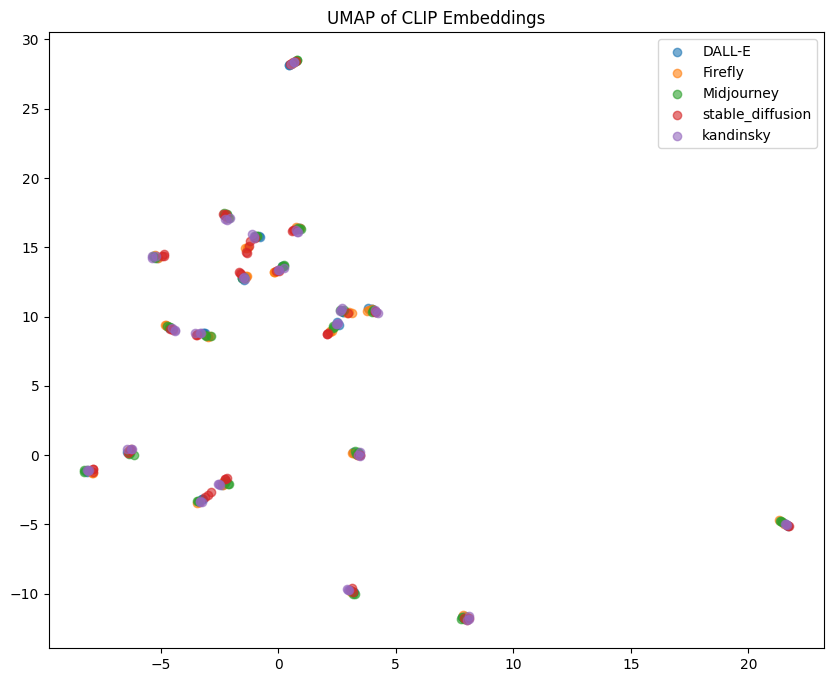

In [ ]:
!pip install umap-learn

import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
coords_umap = reducer.fit_transform(df[embedding_cols])

plt.figure(figsize=(10,8))
for model in models:
    idx = df["model"] == model
    plt.scatter(coords_umap[idx,0], coords_umap[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title("UMAP of CLIP Embeddings")
plt.show()


In [ ]:
import re

def extract_prompt_id(row):
    filename = row["filename"]

    # Remove file extension
    name_part = filename.rsplit(".", 1)[0]

    # For formats like:
    #   DALL-E 0.0.png
    #   Firefly 0.0.png
    #   sd_0_0.png
    #   kandinsky_2_1_0_0.png

    # Find all numbers in name_part
    numbers = re.findall(r"\d+", name_part)

    if "sd_" in filename:
        # Stable Diffusion format: sd_0_0.png → 0_0
        # Take first digit group as prompt ID
        return int(numbers[0])
    elif "kandinsky" in filename:
        # Kandinsky format: kandinsky_2_1_0_0.png
        # The prompt ID is typically the 3rd number
        return int(numbers[2])
    else:
        # All other models like DALL-E, Firefly, Midjourney:
        # Take only the integer **before the dot**
        parts = name_part.split()
        last_part = parts[-1]  # e.g. 0.0
        prompt_id = int(last_part.split(".")[0])
        return prompt_id

df["prompt_id"] = df.apply(extract_prompt_id, axis=1)
print(df[["filename", "model", "prompt_id"]])


                  filename      model  prompt_id
0           DALL-E 0.0.png     DALL-E          0
1           DALL-E 0.1.png     DALL-E          0
2           DALL-E 0.2.png     DALL-E          0
3           DALL-E 1.0.png     DALL-E          1
4           DALL-E 2.0.png     DALL-E          2
..                     ...        ...        ...
295  kandinsky_2_1_8_1.png  kandinsky          8
296  kandinsky_2_1_8_2.png  kandinsky          8
297  kandinsky_2_1_9_0.png  kandinsky          9
298  kandinsky_2_1_9_1.png  kandinsky          9
299  kandinsky_2_1_9_2.png  kandinsky          9

[300 rows x 3 columns]


In [ ]:
prompt_counts = df.groupby(["prompt_id", "model"]).size().unstack(fill_value=0)
print(prompt_counts)


model      DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
prompt_id                                                          
0               3        3           3          3                 3
1               3        3           3          3                 3
2               3        3           3          3                 3
3               3        3           3          3                 3
4               3        3           3          3                 3
5               3        3           3          3                 3
6               3        3           3          3                 3
7               3        3           3          3                 3
8               3        3           3          3                 3
9               3        3           3          3                 3
10              3        3           3          3                 3
11              3        3           3          3                 3
12              3        3           3          

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

prompt_similarities = []

for pid in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == pid]
    models_present = group["model"].unique()

    # Skip prompts that don't exist in at least 2 models
    if len(models_present) < 2:
        continue

    # Compute mean embedding for each model
    mean_embeddings = group.groupby("model")[embedding_cols].mean()

    # Pairwise comparisons
    for m1, m2 in combinations(models_present, 2):
        emb1 = mean_embeddings.loc[m1].values.reshape(1, -1)
        emb2 = mean_embeddings.loc[m2].values.reshape(1, -1)
        sim = cosine_similarity(emb1, emb2)[0,0]
        prompt_similarities.append({
            "prompt_id": pid,
            "model1": m1,
            "model2": m2,
            "similarity": sim
        })

prompt_sim_df = pd.DataFrame(prompt_similarities)
print(prompt_sim_df.head())


   prompt_id   model1            model2  similarity
0          0   DALL-E           Firefly    0.857436
1          0   DALL-E        Midjourney    0.862892
2          0   DALL-E  stable_diffusion    0.862778
3          0   DALL-E         kandinsky    0.907007
4          0  Firefly        Midjourney    0.882863


In [ ]:
avg_sim = prompt_sim_df.groupby(["model1", "model2"])["similarity"].mean().reset_index()
print(avg_sim)


             model1            model2  similarity
0            DALL-E           Firefly    0.853031
1            DALL-E        Midjourney    0.885129
2            DALL-E         kandinsky    0.886584
3            DALL-E  stable_diffusion    0.815420
4           Firefly        Midjourney    0.858032
5           Firefly         kandinsky    0.869942
6           Firefly  stable_diffusion    0.832362
7        Midjourney         kandinsky    0.888418
8        Midjourney  stable_diffusion    0.819312
9  stable_diffusion         kandinsky    0.853606


In [ ]:
lowest = prompt_sim_df.sort_values("similarity").head(10)
print("Prompts with least agreement across models:")
print(lowest)


Prompts with least agreement across models:
     prompt_id            model1            model2  similarity
85           8           Firefly  stable_diffusion    0.618624
189         18  stable_diffusion         kandinsky    0.619028
182         18            DALL-E  stable_diffusion    0.636972
40           4            DALL-E           Firefly    0.678467
120         12            DALL-E           Firefly    0.694365
186         18           Firefly         kandinsky    0.696401
82           8            DALL-E  stable_diffusion    0.705562
87           8        Midjourney  stable_diffusion    0.711380
44           4           Firefly        Midjourney    0.714959
159         15  stable_diffusion         kandinsky    0.718953


In [ ]:
for pid in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == pid]
    models_present = group["model"].unique()

    if len(models_present) < 2:
        continue

    print(f"Prompt {pid}:")
    for model in models_present:
        sub = group[group["model"] == model]
        if len(sub) > 1:
            sim = cosine_similarity(sub[embedding_cols].values)
            upper = sim[np.triu_indices_from(sim, k=1)]
            avg_sim = upper.mean() if len(upper) else 1.0
            print(f"   Intra-similarity for {model}: {avg_sim:.3f}")
    print()


Prompt 0:
   Intra-similarity for DALL-E: 0.967
   Intra-similarity for Firefly: 0.914
   Intra-similarity for Midjourney: 0.917
   Intra-similarity for stable_diffusion: 0.794
   Intra-similarity for kandinsky: 0.938

Prompt 1:
   Intra-similarity for DALL-E: 0.942
   Intra-similarity for Firefly: 0.952
   Intra-similarity for Midjourney: 0.929
   Intra-similarity for stable_diffusion: 0.841
   Intra-similarity for kandinsky: 0.945

Prompt 2:
   Intra-similarity for DALL-E: 0.963
   Intra-similarity for Firefly: 0.906
   Intra-similarity for Midjourney: 0.945
   Intra-similarity for stable_diffusion: 0.744
   Intra-similarity for kandinsky: 0.954

Prompt 3:
   Intra-similarity for DALL-E: 0.964
   Intra-similarity for Firefly: 0.951
   Intra-similarity for Midjourney: 0.848
   Intra-similarity for stable_diffusion: 0.743
   Intra-similarity for kandinsky: 0.921

Prompt 4:
   Intra-similarity for DALL-E: 0.912
   Intra-similarity for Firefly: 0.897
   Intra-similarity for Midjourney: 0

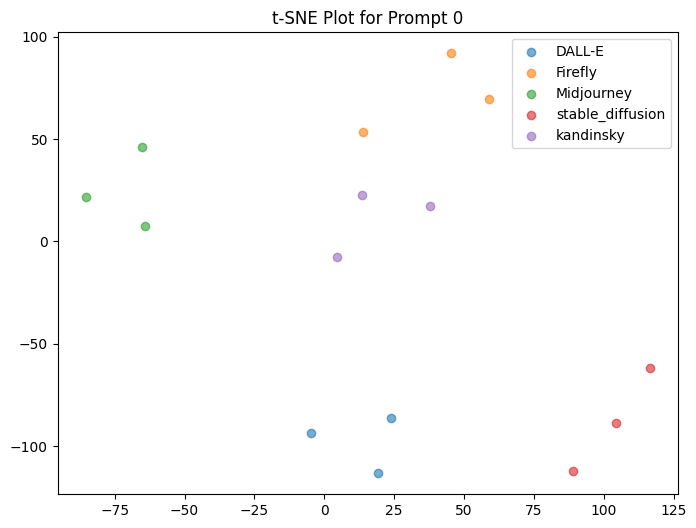

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Pick a prompt ID to visualize:
prompt_id = 0

group = df[df["prompt_id"] == prompt_id]

# Run t-SNE on only this prompt's images
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
coords = tsne.fit_transform(group[embedding_cols])

# Plot
plt.figure(figsize=(8,6))
for model in group["model"].unique():
    idx = group["model"] == model
    plt.scatter(coords[idx,0], coords[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title(f"t-SNE Plot for Prompt {prompt_id}")
plt.show()


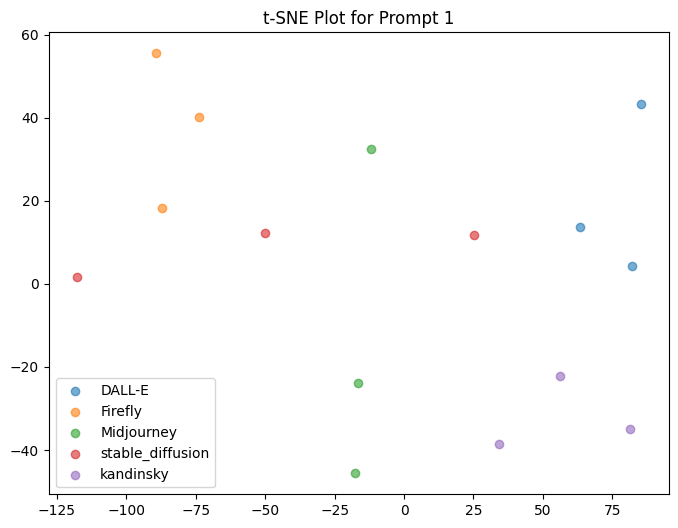

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Pick a prompt ID to visualize:
prompt_id = 1

group = df[df["prompt_id"] == prompt_id]

# Run t-SNE on only this prompt's images
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
coords = tsne.fit_transform(group[embedding_cols])

# Plot
plt.figure(figsize=(8,6))
for model in group["model"].unique():
    idx = group["model"] == model
    plt.scatter(coords[idx,0], coords[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title(f"t-SNE Plot for Prompt {prompt_id}")
plt.show()


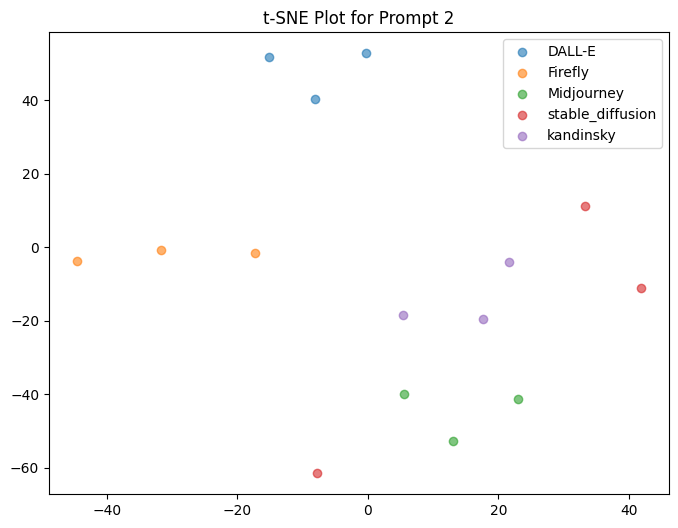

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Pick a prompt ID to visualize:
prompt_id = 2

group = df[df["prompt_id"] == prompt_id]

# Run t-SNE on only this prompt's images
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
coords = tsne.fit_transform(group[embedding_cols])

# Plot
plt.figure(figsize=(8,6))
for model in group["model"].unique():
    idx = group["model"] == model
    plt.scatter(coords[idx,0], coords[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title(f"t-SNE Plot for Prompt {prompt_id}")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# Pick your prompt ID
prompt_id = 3

# Subset images for this prompt
group = df[df["prompt_id"] == prompt_id]

# Optional: reduce dims to 10 first for stability
from sklearn.decomposition import PCA
pca = PCA(n_components=10, random_state=42)
embeds_reduced = pca.fit_transform(group[embedding_cols])

# Cluster
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeds_reduced)

group = group.copy()
group["cluster"] = labels

# See how many images per model fall into each cluster
cluster_summary = pd.crosstab(group["cluster"], group["model"])
print(cluster_summary)


model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             0        3           0          0                 0
1             0        0           2          3                 2
2             3        0           1          0                 1


In [ ]:
mean_embeddings_list = []

for pid in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == pid]
    means = group.groupby("model")[embedding_cols].mean()
    for model in means.index:
        mean_embeddings_list.append({
            "prompt_id": pid,
            "model": model,
            **dict(zip(embedding_cols, means.loc[model].values))
        })

means_df = pd.DataFrame(mean_embeddings_list)


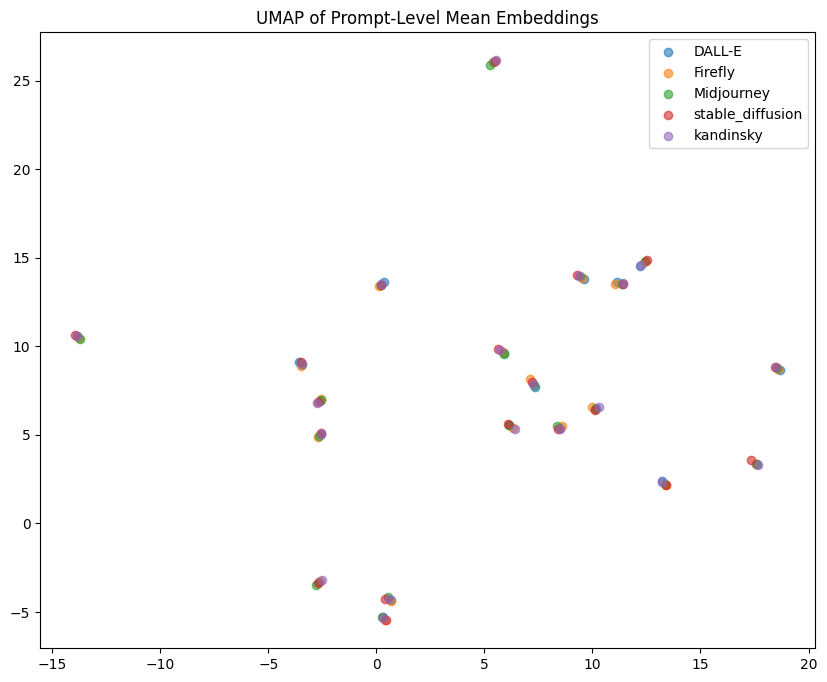

In [ ]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='cosine', random_state=42)

coords = reducer.fit_transform(means_df[embedding_cols])

means_df["x"] = coords[:,0]
means_df["y"] = coords[:,1]

plt.figure(figsize=(10,8))
for model in models:
    idx = means_df["model"] == model
    plt.scatter(means_df.loc[idx,"x"], means_df.loc[idx,"y"], label=model, alpha=0.6)

plt.legend()
plt.title("UMAP of Prompt-Level Mean Embeddings")
plt.show()


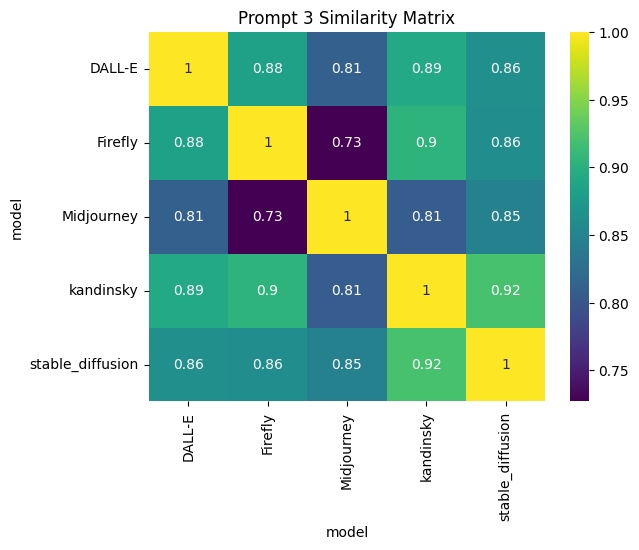

In [ ]:
import seaborn as sns

# For one prompt:
pid = 3

group = df[df["prompt_id"] == pid]
means = group.groupby("model")[embedding_cols].mean()
cos_sim = cosine_similarity(means.values)
sim_df = pd.DataFrame(cos_sim, index=means.index, columns=means.index)

sns.heatmap(sim_df, annot=True, cmap="viridis")
plt.title(f"Prompt {pid} Similarity Matrix")
plt.show()


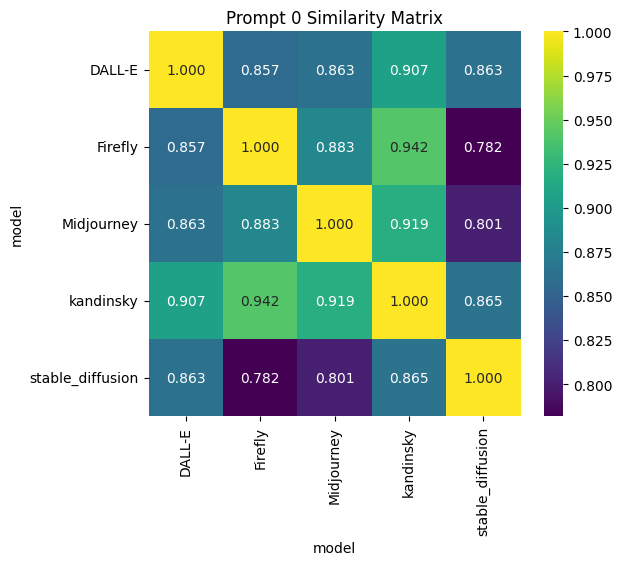

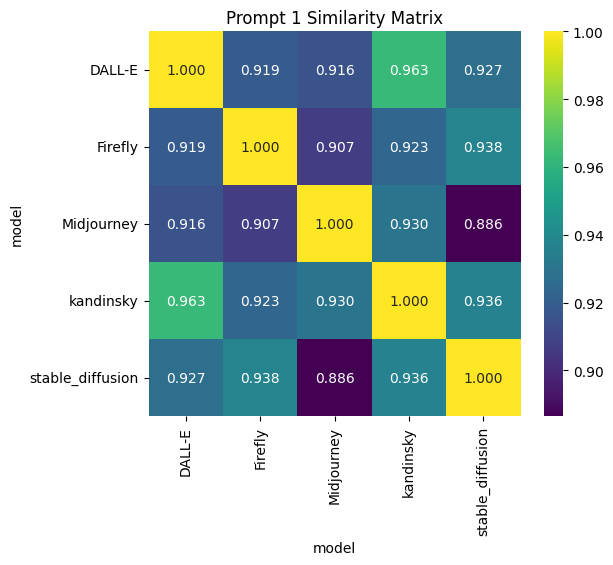

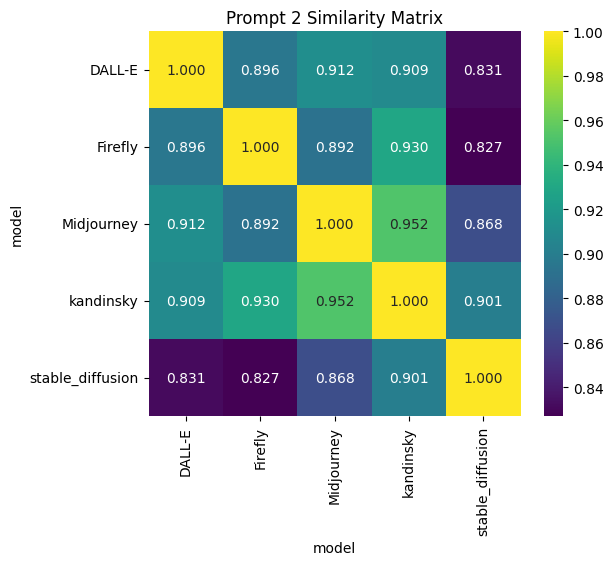

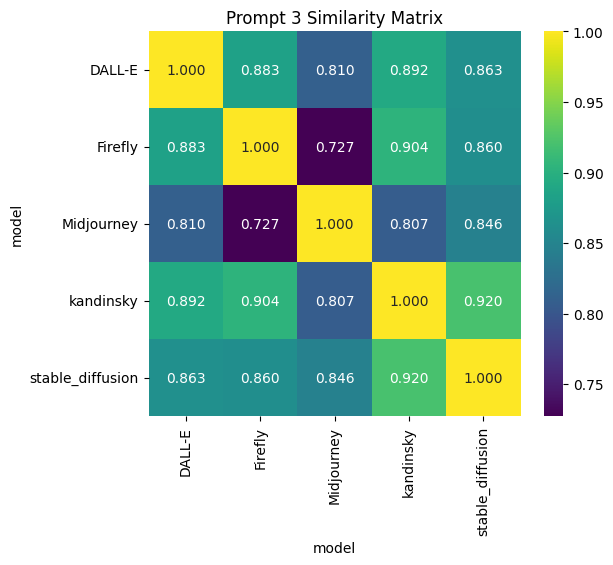

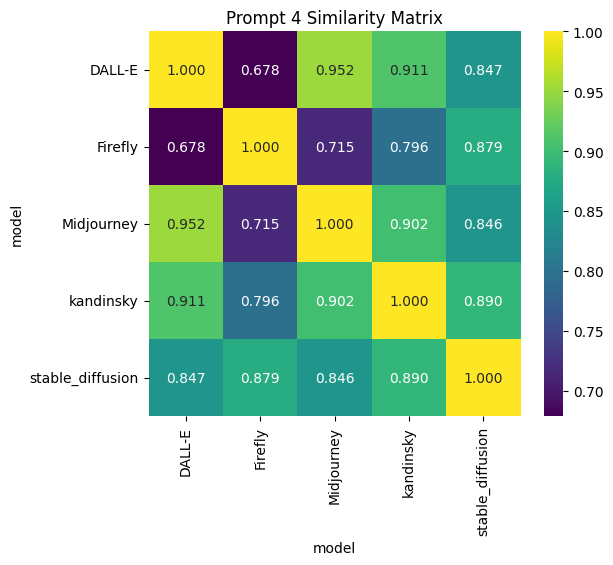

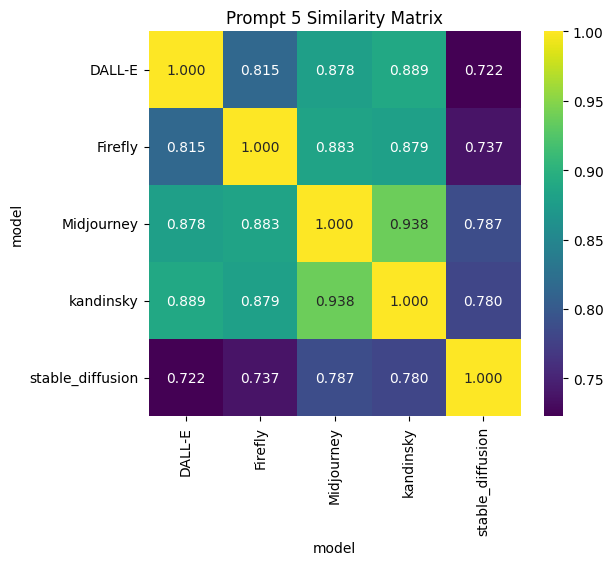

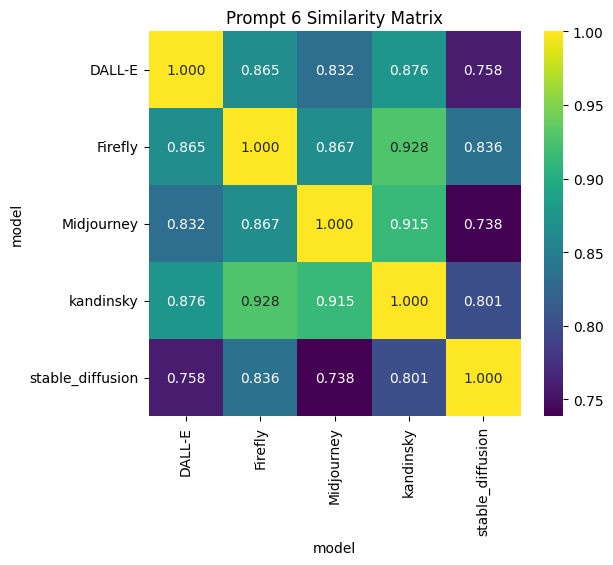

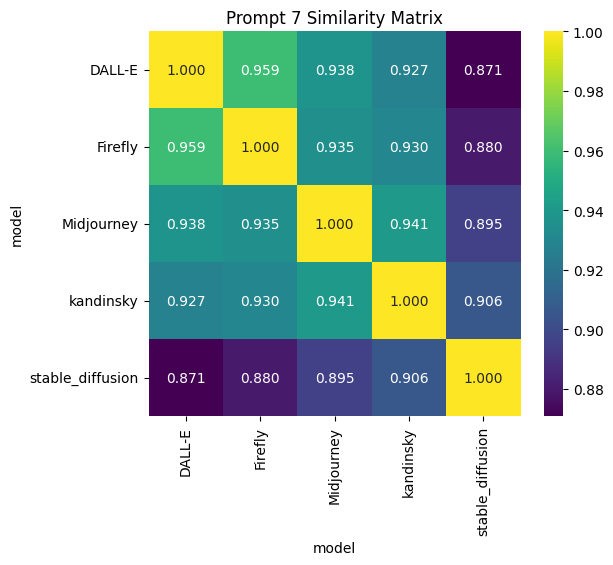

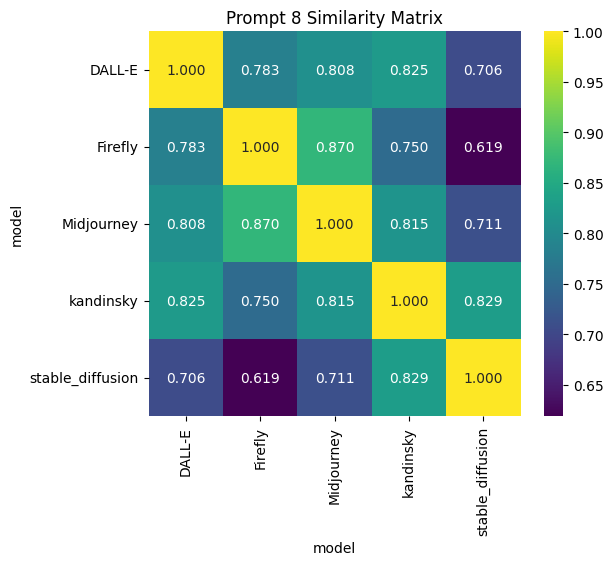

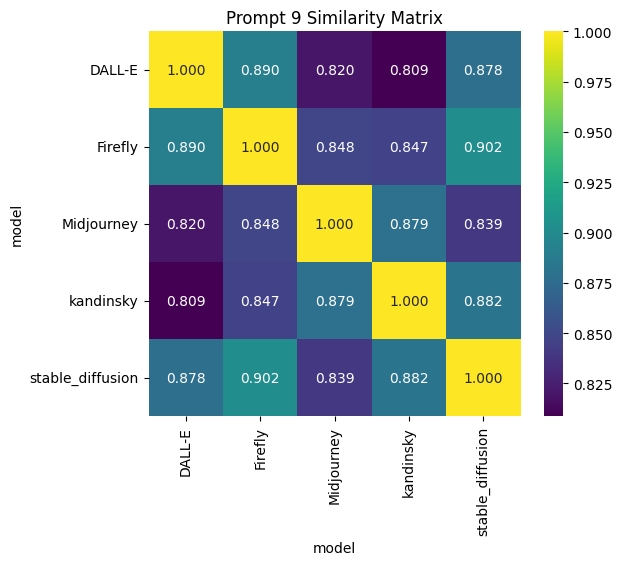

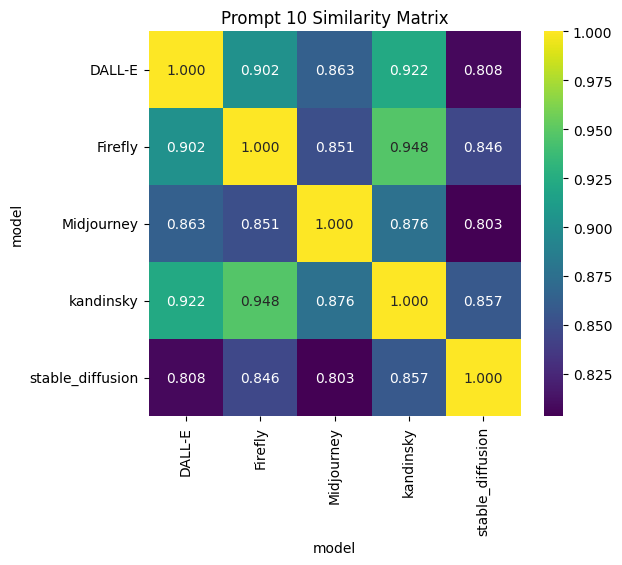

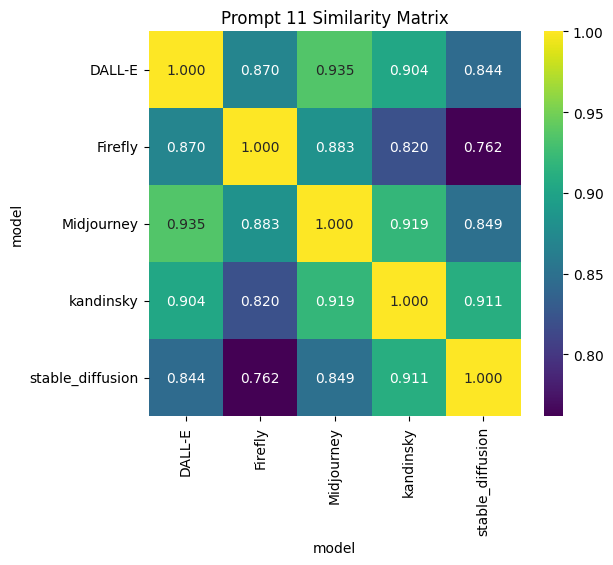

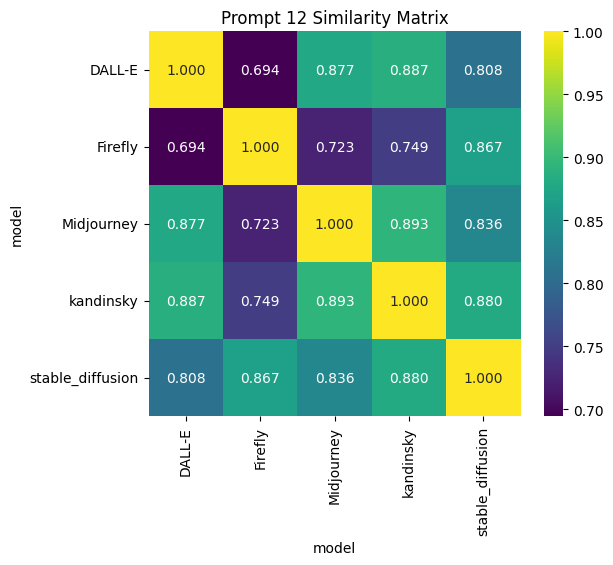

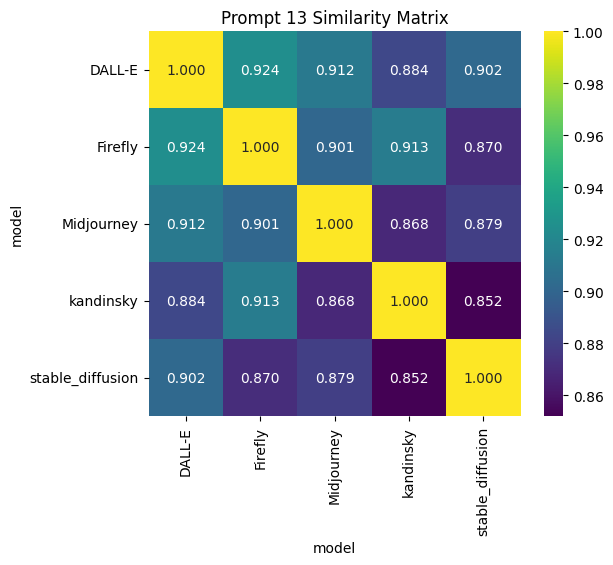

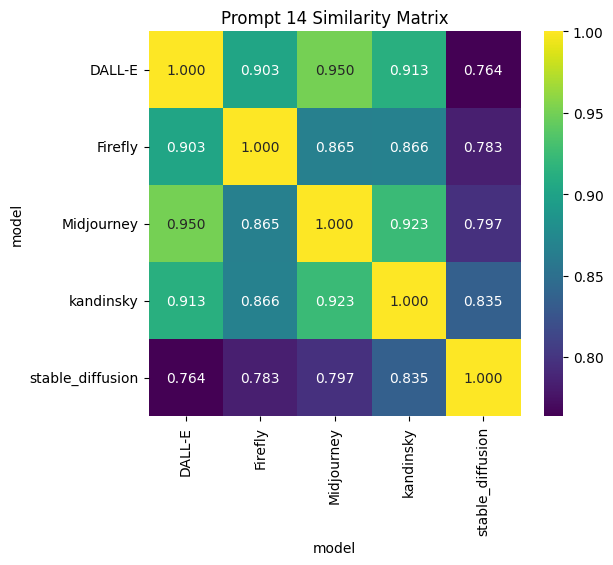

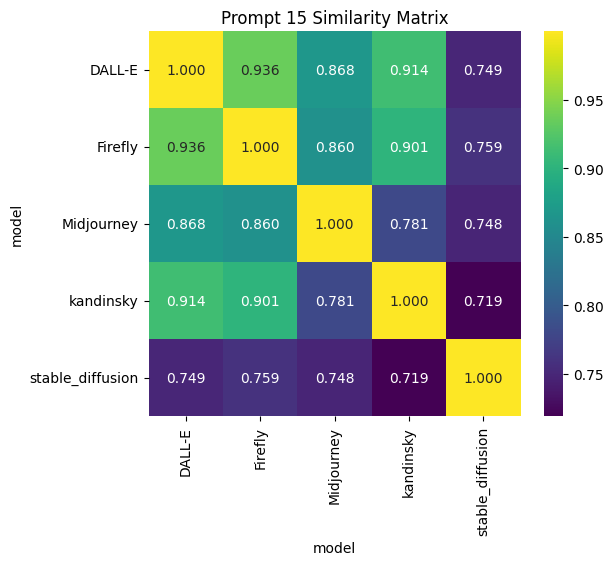

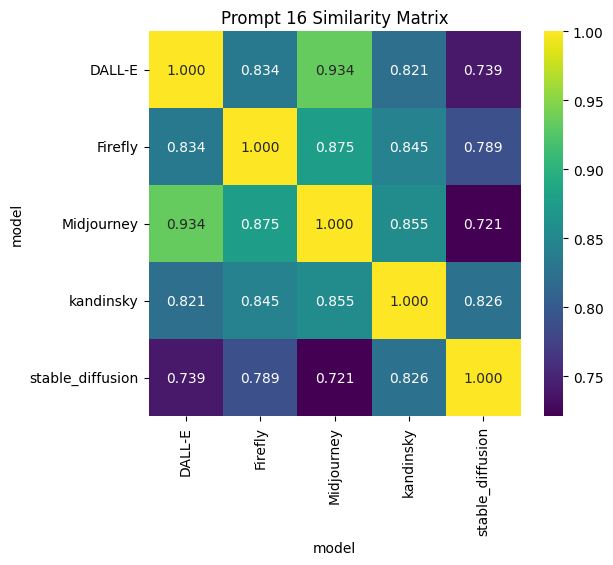

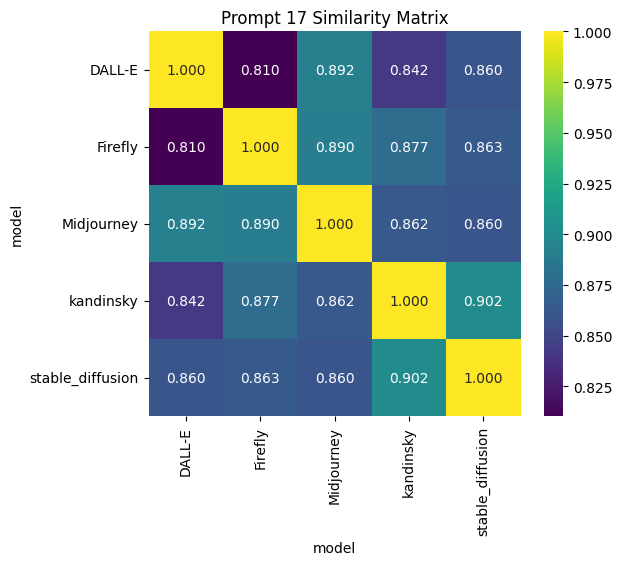

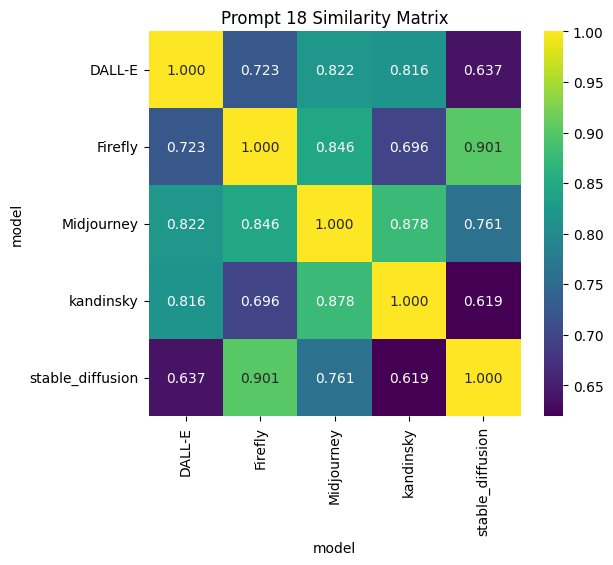

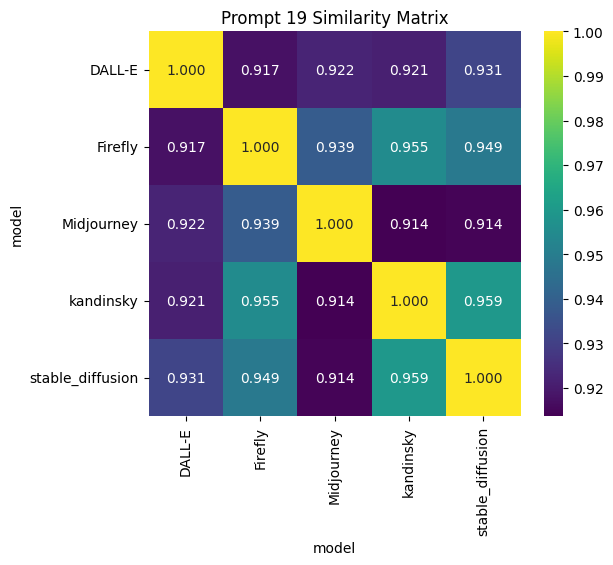

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Get unique prompt IDs
prompt_ids = sorted(df["prompt_id"].unique())

for pid in prompt_ids:
    # Subset to images for this prompt
    group = df[df["prompt_id"] == pid]

    # Check how many models exist for this prompt
    models_present = group["model"].unique()

    # Skip if fewer than 2 models have images
    if len(models_present) < 2:
        print(f"Skipping prompt {pid} (only 1 model present)")
        continue

    # Compute mean embeddings for each model
    means = group.groupby("model")[embedding_cols].mean()

    # Compute pairwise cosine similarities
    cos_sim = cosine_similarity(means.values)

    # Format as DataFrame
    sim_df = pd.DataFrame(
        cos_sim,
        index=means.index,
        columns=means.index
    )

    # Plot heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(sim_df, annot=True, cmap="viridis", fmt=".3f")
    plt.title(f"Prompt {pid} Similarity Matrix")
    plt.show()
